In [ ]:
pip install sqlalchemy psycopg2-binary python-dotenv elasticsearch openai scikit-learn hdbscan

# + Imports & Env setup

In [339]:
import os
import time
import json
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

load_dotenv()

user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
dbname = os.getenv("POSTGRES_DB")

In [125]:
colors = [
    "red", "blue", "green", "yellow", "cyan", "magenta", "black", "white",
    "darkorange", "lightblue", "lime", "gold", "purple", "pink",
    "b", "g", "r", "c", "m", "y", "k", "w",
    "#FF5733",
    "xkcd:sky blue",
    "xkcd:grass green"
]

In [126]:
from sqlalchemy import create_engine, text
import pandas as pd


engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}", connect_args={"options": "-c statement_timeout=7500"})

# + Helper functions

In [127]:
# measures delta time between the start and the end of the query execution, with many iterations
def measure_time(sql, engine=engine, n_runs=5):
    runtimes = []
    for _ in range(n_runs):
        start = time.perf_counter()
        _df = pd.read_sql(sql, engine) # returns the entire result, needs to be limited in very big tables
        end = time.perf_counter()
        runtimes.append(end - start)
    return runtimes

# returns stats on the execution iterations
def summarize(times_list):
    return {
        "total": sum(times_list),
        "min": min(times_list),
        "max": max(times_list),
        "mean": sum(times_list) / len(times_list),
        "median": sorted(times_list)[len(times_list)//2]
    }

def show_summary(summary):
    print(40*"=", "Query Benchmark", "="*43)
    print("-"*100)
    print("Total   time:", str(int(1e3*summary["total"])) + "ms")
    print("Minimum time:", str(int(1e3*summary["min"])) + "ms")
    print("Maximum time:", str(int(1e3*summary["max"])) + "ms")
    print("Mean    time:", str(int(1e3*summary["mean"])) + "ms")
    print("Median  time:", str(int(1e3*summary["median"])) + "ms")
    print("-"*100)
    print("="*100)

def explain_analyse(sql):
    print(40*"=", "EXPLAIN ANALYSE", "="*43)
    print("-"*100)
    explain_query = f"EXPLAIN ANALYZE {sql}"
    with engine.begin() as conn:  
        result = conn.execute(text(explain_query))
        plan = result.fetchall()

        for row in plan:
            print(row[0])
    print("-"*100)
    print("="*100)

def create_index(name, on_table, on_columns, condition='', engine=engine):
    n_on_columns = on_columns
    q_on_columns = on_columns
    if type(on_columns) == list:
        n_on_columns = "_".join(on_columns)
        q_on_columns = ",".join(on_columns)

    if not name: name = f"index_{on_table}_{n_on_columns}"

    sql = f"CREATE INDEX CONCURRENTLY IF NOT EXISTS {name} ON {on_table}({q_on_columns})"

    if condition: sql += " WHERE " + condition.strip()

    with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
        result = conn.execute(text(sql))
        try:
            plan = result.fetchall()
            for row in plan:
                print(row[0])
        except: 
            pass
    
def drop_index(name, engine=engine):
    fq_name = name
    parts = ["DROP INDEX"]
    parts.append("CONCURRENTLY")
    parts.append("IF EXISTS")
    parts.append(fq_name)
    sql = " ".join(parts)

    isolation_opts = {}
    isolation_opts = {"isolation_level": "AUTOCOMMIT"}

    check_query = text("""
        SELECT 1 FROM pg_class c 
        JOIN pg_namespace n ON n.oid = c.relnamespace 
        WHERE c.relname = :index_name 
        AND c.relkind = 'i'
        AND n.nspname = 'public'
    """)

    with engine.connect().execution_options(**isolation_opts) as conn:
        result = conn.execute(check_query, {"index_name": name}).fetchone()
        if result: 
            conn.execute(text(sql))
            print(f"✔ Index '{name}' dropped (if it existed).")
        else:
            print("No Index named '{name}' was found !")

def execute_expression(sql):
    with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
        conn.execute(text(sql))

def refresh_category_rev_MV(name):
    with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
        stmt = "REFRESH MATERIALIZED VIEW "
        stmt += "CONCURRENTLY "
        stmt += name + ";" 
        conn.execute(text(stmt))

# ============================ Matplotlib functions =============================;

def plot_different_results(approach_iterations: list, approach_labels: list):
    assert len(approach_labels) == len(approach_iterations)
    assert len(approach_labels)
    x = np.linspace(0, 10, len(approach_iterations[0]))
    ys = [y for y in approach_iterations]

    for i, y in enumerate(ys):
        avg_y = np.mean(y)
        plt.plot(x, y, label=approach_labels[i], linestyle="solid", color=colors[i % len(colors)])
        plt.axhline(avg_y, color=colors[i % len(colors)], linestyle="dotted", label=f"Avg({approach_labels[i]})")

    plt.xlabel("Iterations")
    plt.ylabel("Time")
    plt.title("Benchmark Plot: "+ (" VS ".join(approach_labels)))
    plt.legend()

    plt.show()

    

# Part I: Data Exploration & SQL Query Optimization

In [128]:
drop_index(
    name="idx_events_timestamp_userid"
)

No Index named '{name}' was found !


In [129]:
weekly_active_users_query = """
SELECT
    DATE_TRUNC('week', timestamp) AS week_start,
    COUNT(DISTINCT user_id) AS weekly_active_users
FROM events
GROUP BY week_start
ORDER BY week_start;
"""
print(15*"-", "Weekly Active Users", "-"*15)
weekly_active_users = pd.read_sql(weekly_active_users_query, engine)
print(weekly_active_users.head(10))
print("-"*50)
print("Shape:", weekly_active_users.shape)

--------------- Weekly Active Users ---------------
  week_start  weekly_active_users
0 2024-01-01                    9
1 2024-01-08                   18
2 2024-01-15                   33
3 2024-01-22                   43
4 2024-01-29                   46
5 2024-02-05                   51
6 2024-02-12                   53
7 2024-02-19                   66
8 2024-02-26                   70
9 2024-03-04                   69
--------------------------------------------------
Shape: (72, 2)


In [130]:
weekly_active_iters = measure_time(weekly_active_users_query, n_runs=500)
weekly_active_q_summary = summarize(weekly_active_iters)
show_summary(weekly_active_q_summary)

print()

explain_analyse(weekly_active_users_query)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 9109ms
Minimum time: 16ms
Maximum time: 28ms
Mean    time: 18ms
Median  time: 17ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
GroupAggregate  (cost=1330.47..1628.71 rows=14910 width=16) (actual time=4.497..12.245 rows=72 loops=1)
  Group Key: (date_trunc('week'::text, "timestamp"))
  ->  Sort  (cost=1330.47..1367.76 rows=14916 width=14) (actual time=4.474..5.162 rows=14916 loops=1)
        Sort Key: (date_trunc('week'::text, "timestamp"))
        Sort Method: quicksort  Memory: 1200kB
        ->  Seq Scan on events  (

In [131]:
weekly_active_sub_q = """
SELECT week_start, COUNT(*) AS weekly_active_users
FROM (
    SELECT DISTINCT 
        DATE_TRUNC('week', timestamp) AS week_start,
        user_id
    FROM events
) unique_week_users
GROUP BY week_start
ORDER BY week_start;
"""
# print(15*"-", "Optimized - Weekly Active Users", "-"*15)
# weekly_active_sub = pd.read_sql(weekly_active_sub_q, engine)
# print(weekly_active_sub.head(10))
# print("-"*50)
# print("Shape:", weekly_active_sub.shape)

# Same result

In [132]:
weekly_active_sub_iters = measure_time(weekly_active_sub_q, n_runs=500)
weekly_active_sub_summary = summarize(weekly_active_sub_iters)
show_summary(weekly_active_sub_summary)

print()

explain_analyse(weekly_active_sub_q)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 5762ms
Minimum time: 9ms
Maximum time: 16ms
Mean    time: 11ms
Median  time: 11ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
Sort  (cost=790.70..791.20 rows=200 width=16) (actual time=6.559..6.563 rows=72 loops=1)
  Sort Key: (date_trunc('week'::text, events."timestamp"))
  Sort Method: quicksort  Memory: 28kB
  ->  HashAggregate  (cost=781.05..783.05 rows=200 width=16) (actual time=6.520..6.529 rows=72 loops=1)
        Group Key: (date_trunc('week'::text, events."timestamp"))
        Batches: 1  Memory Usage: 40kB
  

In [133]:
create_index(
    name="idx_events_timestamp_userid",
    on_table="events",
    on_columns=["timestamp", "user_id"]
)

In [134]:
idx_weekly_active_iters = measure_time(weekly_active_sub_q, n_runs=500) # using the same query as before because we just added an index, without changing the query
idx_weekly_active_summary = summarize(idx_weekly_active_iters)
show_summary(idx_weekly_active_summary)

print()

explain_analyse(weekly_active_sub_q)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 5423ms
Minimum time: 9ms
Maximum time: 15ms
Mean    time: 10ms
Median  time: 10ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
Sort  (cost=790.70..791.20 rows=200 width=16) (actual time=5.690..5.694 rows=72 loops=1)
  Sort Key: (date_trunc('week'::text, events."timestamp"))
  Sort Method: quicksort  Memory: 28kB
  ->  HashAggregate  (cost=781.05..783.05 rows=200 width=16) (actual time=5.672..5.679 rows=72 loops=1)
        Group Key: (date_trunc('week'::text, events."timestamp"))
        Batches: 1  Memory Usage: 40kB
  

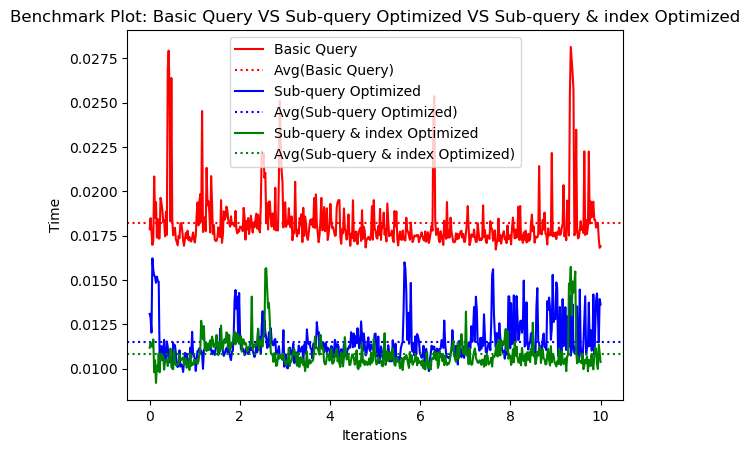

In [135]:
plot_different_results(
    approach_iterations=[
        weekly_active_iters,
        weekly_active_sub_iters,
        idx_weekly_active_iters
    ],
    approach_labels=[
        "Basic Query",
        "Sub-query Optimized",
        "Sub-query & index Optimized"
    ]
)

**!) Making sure no indices are created before testing the basic query**

In [136]:
drop_index(name="events_purchased_product_id") # removing the partial index on product ids only on purchased products
drop_index(name="mv_category_revenue_pkey") # removing the index on the matrialized view, on category

No Index named '{name}' was found !
No Index named '{name}' was found !


In [137]:
per_category_revenue_query = """
SELECT
    p.category,
    SUM(p.price) as total_revenue
FROM events e
LEFT JOIN products p 
ON e.product_id = p.product_id
WHERE e.event_type = 'purchased'
GROUP BY p.category
ORDER BY total_revenue DESC;
"""

per_category_revenue = pd.read_sql(per_category_revenue_query, engine)

print(per_category_revenue.head(10))

      category  total_revenue
0  electronics      190340.67
1         home       70597.60
2         toys       51313.21
3     clothing       37100.84
4       sports       28075.11
5       beauty       14826.63
6        books       10918.25


In [138]:
per_category_revenue_iters = measure_time(per_category_revenue_query, n_runs=500)
per_category_revenue_summary = summarize(per_category_revenue_iters)
show_summary(per_category_revenue_summary)

print()

explain_analyse(per_category_revenue_query)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 3264ms
Minimum time: 5ms
Maximum time: 16ms
Mean    time: 6ms
Median  time: 6ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
Sort  (cost=317.13..317.15 rows=7 width=39) (actual time=1.727..1.728 rows=7 loops=1)
  Sort Key: (sum(p.price)) DESC
  Sort Method: quicksort  Memory: 25kB
  ->  HashAggregate  (cost=316.95..317.04 rows=7 width=39) (actual time=1.718..1.721 rows=7 loops=1)
        Group Key: p.category
        Batches: 1  Memory Usage: 24kB
        ->  Hash Left Join  (cost=3.25..305.80 rows=2230 width=13) (actua

In [139]:
create_index(name="events_purchased_product_id",on_table="events", on_columns="product_id", condition="event_type = 'purchased'")

In [140]:
opt_category_revenue_query = """
WITH purchased_per_product AS (
    SELECT product_id, COUNT(*) AS qty
    FROM   events
    WHERE  event_type = 'purchased'
    GROUP  BY product_id
)
SELECT  p.category,
        SUM(p.price * pp.qty) AS total_revenue
FROM     purchased_per_product pp
JOIN     products           p ON p.product_id = pp.product_id
GROUP BY p.category
ORDER BY total_revenue DESC;
"""

opt_category_revenue = pd.read_sql(opt_category_revenue_query, engine)

print(opt_category_revenue.head(10))

      category  total_revenue
0  electronics      190340.67
1         home       70597.60
2         toys       51313.21
3     clothing       37100.84
4       sports       28075.11
5       beauty       14826.63
6        books       10918.25


In [141]:
opt_category_revenue_iters = measure_time(opt_category_revenue_query, n_runs=500)
opt_category_revenue_summary = summarize(opt_category_revenue_iters)
show_summary(opt_category_revenue_summary)

print()

explain_analyse(opt_category_revenue_query)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 2592ms
Minimum time: 4ms
Maximum time: 7ms
Mean    time: 5ms
Median  time: 5ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
Sort  (cost=71.59..71.61 rows=7 width=39) (actual time=0.336..0.337 rows=7 loops=1)
  Sort Key: (sum((p.price * ((count(*)))::numeric))) DESC
  Sort Method: quicksort  Memory: 25kB
  ->  HashAggregate  (cost=71.40..71.49 rows=7 width=39) (actual time=0.329..0.331 rows=7 loops=1)
        Group Key: p.category
        Batches: 1  Memory Usage: 24kB
        ->  Hash Join  (cost=3.53..70.40 rows=100 wi

In [142]:
mat_view_category_rev_q = """
CREATE MATERIALIZED VIEW IF NOT EXISTS mv_category_revenue AS
SELECT p.category,
       SUM(p.price) AS total_revenue
FROM   events   e
JOIN   products p ON p.product_id = e.product_id
WHERE  e.event_type = 'purchased'
GROUP  BY p.category;
"""

In [143]:
# This creates a MATERIALIZED VIEW
execute_expression(mat_view_category_rev_q)

In [144]:
create_index(name="mv_category_revenue_pkey", on_table="mv_category_revenue", on_columns="category")

In [145]:
category_revenue_query = "SELECT category, total_revenue FROM mv_category_revenue ORDER BY total_revenue DESC"
category_revenue = pd.read_sql(category_revenue_query, engine)

print(category_revenue.head(10))

      category  total_revenue
0  electronics      190340.67
1         home       70597.60
2         toys       51313.21
3     clothing       37100.84
4       sports       28075.11
5       beauty       14826.63
6        books       10918.25


In [146]:
mat_view_category_rev_iters = measure_time(category_revenue_query, n_runs=500)
mat_view_category_rev_sum = summarize(mat_view_category_rev_iters)
show_summary(mat_view_category_rev_sum)

print()

explain_analyse(category_revenue_query)

======================================== Query Benchmark ===========================================
----------------------------------------------------------------------------------------------------
Total   time: 2319ms
Minimum time: 3ms
Maximum time: 6ms
Mean    time: 4ms
Median  time: 4ms
----------------------------------------------------------------------------------------------------

======================================== EXPLAIN ANALYSE ===========================================
----------------------------------------------------------------------------------------------------
Sort  (cost=1.17..1.19 rows=7 width=64) (actual time=0.014..0.015 rows=7 loops=1)
  Sort Key: total_revenue DESC
  Sort Method: quicksort  Memory: 25kB
  ->  Seq Scan on mv_category_revenue  (cost=0.00..1.07 rows=7 width=64) (actual time=0.006..0.007 rows=7 loops=1)
Planning Time: 0.036 ms
Execution Time: 0.024 ms
-------------------------------------------------------------------------------------

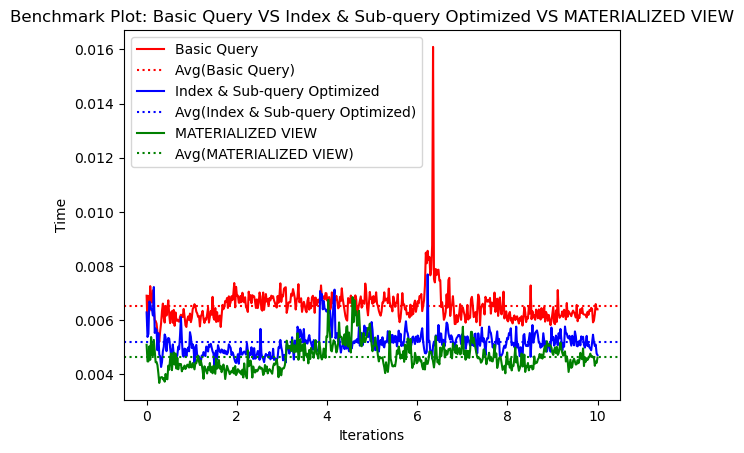

In [147]:
plot_different_results(
    approach_iterations=[
        per_category_revenue_iters,
        opt_category_revenue_iters,
        mat_view_category_rev_iters
    ],
    approach_labels=[
        "Basic Query",
        "Index & Sub-query Optimized",
        "MATERIALIZED VIEW"
    ]
)

# Part II: Cohort analysis

In [148]:
# create month column seperatly for better performance, it will be used later to group by and split the cohorts

# cohort grouping only query
cohort_groupings_query = """
WITH cohorts AS (
    SELECT
        u.user_id,
        DATE_TRUNC('month', u.signup_date)::date AS month,
        u.signup_date::date AS signup_date
    FROM users u
)

SELECT
    month,
    COUNT(*)
FROM cohorts
GROUP  BY month
ORDER  BY month;
"""

# activity CTE has to join the users in cohorts with their events, limit those events to an 8 week period,
# and set up the week_num column that will be used later to create the columns of the matrix
# the final matrix that can be visualized as a heat map

matrix_query = """
WITH cohorts AS (
    SELECT
        u.user_id,
        DATE_TRUNC('month', u.signup_date)::date AS month,
        u.signup_date::date AS signup_date
    FROM users u
),
activity AS (
    SELECT
        c.month,
        c.user_id,
        ((e.timestamp::date - c.signup_date)::int / 7) AS week_num
    FROM   cohorts c
    JOIN   events e USING (user_id)
    WHERE  e.timestamp::date >= c.signup_date
      AND  e.timestamp::date <  c.signup_date + INTERVAL '8 weeks'
)

SELECT
    month,
    COUNT(DISTINCT user_id)                                      AS users_in_cohort,
    COUNT(DISTINCT CASE WHEN week_num = 0 THEN user_id END)      AS wk0,
    COUNT(DISTINCT CASE WHEN week_num = 1 THEN user_id END)      AS wk1,
    COUNT(DISTINCT CASE WHEN week_num = 2 THEN user_id END)      AS wk2,
    COUNT(DISTINCT CASE WHEN week_num = 3 THEN user_id END)      AS wk3,
    COUNT(DISTINCT CASE WHEN week_num = 4 THEN user_id END)      AS wk4,
    COUNT(DISTINCT CASE WHEN week_num = 5 THEN user_id END)      AS wk5,
    COUNT(DISTINCT CASE WHEN week_num = 6 THEN user_id END)      AS wk6,
    COUNT(DISTINCT CASE WHEN week_num = 7 THEN user_id END)      AS wk7
FROM   activity
GROUP  BY month
ORDER  BY month;
"""

## 1. Monthly Cohorts:

In [149]:
print(18*"-", "Cohort Groups", "-"*18)
cohort_groupings = pd.read_sql(cohort_groupings_query, engine)
print(cohort_groupings.head(10))
print("-"*50)
print("Shape:", cohort_groupings.shape)

------------------ Cohort Groups ------------------
        month  count
0  2024-01-01     87
1  2024-02-01     83
2  2024-03-01     80
3  2024-04-01     85
4  2024-05-01     89
5  2024-06-01     81
6  2024-07-01     82
7  2024-08-01     87
8  2024-09-01     81
9  2024-10-01     79
--------------------------------------------------
Shape: (12, 2)


## 2. Count how many users were active for each cohort

In [ ]:
print(18*"-", "Retention Matrix", "-"*18)
retention_matrix_df = pd.read_sql(matrix_query, engine)
print(retention_matrix_df.head(10))
print("-"*50)
print("Shape:", retention_matrix_df.shape)

------------------ Retention Matrix ------------------
        month  users_in_cohort  wk0  wk1  wk2  wk3  wk4  wk5  wk6  wk7
0  2024-01-01               80   46   39   30   19   20    8    8    8
1  2024-02-01               79   53   43   31   24   18   13   10    4
2  2024-03-01               75   46   31   31   20   13   11    9    8
3  2024-04-01               83   50   44   46   39   32   29   26   26
4  2024-05-01               89   59   54   55   41   32   28   24   38
5  2024-06-01               81   45   46   39   28   27   35   31   23
6  2024-07-01               74   51   45   29   27   12   12   11    3
7  2024-08-01               80   54   35   32   21   10    6    9   10
8  2024-09-01               74   49   36   28   18   16   10   11    3
9  2024-10-01               70   43   38   21   17   11   14   14    6
--------------------------------------------------
Shape: (12, 10)


## 3. Heat map of the retention matrix

In [ ]:
week_cols = [f"wk{i}" for i in range(8)]
retention_matrix_df[week_cols] = retention_matrix_df[week_cols].div(retention_matrix_df["users_in_cohort"], axis=0)

retention = (
    retention_matrix_df
    .set_index("month")
    .sort_index()
)[week_cols]

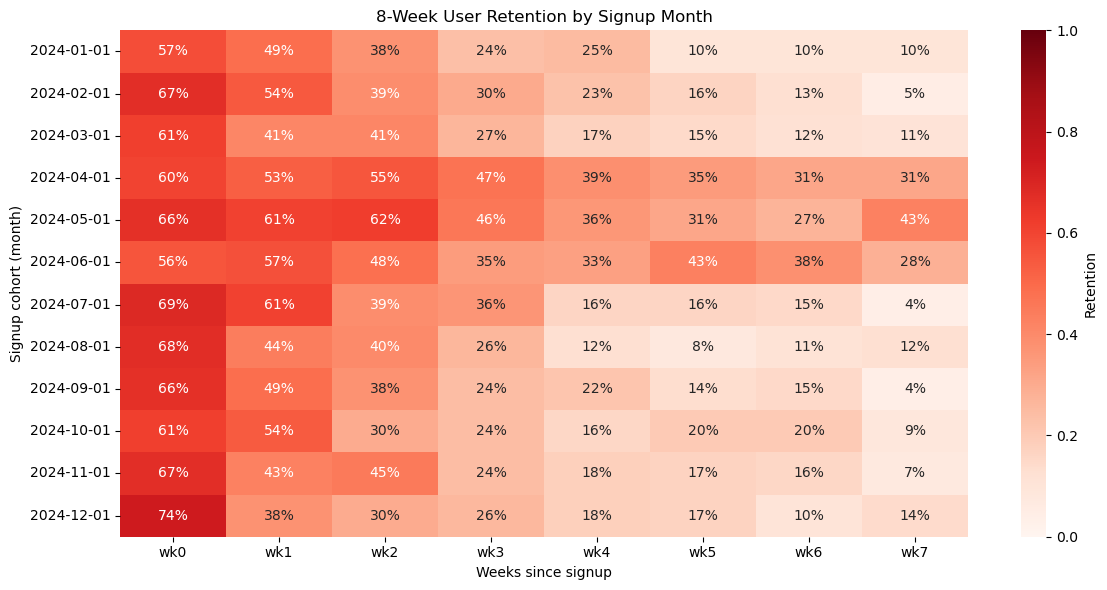

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention,
    # mask=mask,
    annot=True,
    fmt=".0%",
    cmap="Reds",
    vmin=0, vmax=1,
    cbar_kws={"label": "Retention"}
)
plt.title("8-Week User Retention by Signup Month")
plt.ylabel("Signup cohort (month)")
plt.xlabel("Weeks since signup")
plt.tight_layout()
plt.show()


# Part III: Behavioral Segmentation with Elasticsearch & AI

In [ ]:
from elasticsearch import Elasticsearch, helpers

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import hdbscan

from openai import OpenAI

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=OPENAI_API_KEY)


es = Elasticsearch(
    hosts=[{"host": "localhost", "port": 9200, "scheme": "http"}],
    request_timeout=30,
    max_retries=3,
    retry_on_timeout=True
)

INDEX_NAME = "user_searches"

## 1. Retrieval of user search data 

In [ ]:
# using scan incase we have more than 10,000 docs
hits = helpers.scan(es, index=INDEX_NAME, query={"query": {"match_all": {}}}, size=100, scroll="5m")

user_id_query_pairs = []
longest_sequence_len = 0
for i, hit in enumerate(hits):
    if i % 1000 == 0: print(f"Reached {i} rows")

    user_id = hit["_source"]["user_id"]
    search_query = hit["_source"]["search_query"]
    user_id_query_pairs.append((user_id, search_query))

    current_len = len(search_query.split())
    if current_len > longest_sequence_len:
        longest_sequence_len = current_len

C:\Users\oussa\AppData\Local\Temp\ipykernel_35572\3968095042.py:6: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  for i, hit in enumerate(hits):


Reached 0 rows
Reached 1000 rows
Reached 2000 rows
Reached 3000 rows
Reached 4000 rows
Reached 5000 rows
Reached 6000 rows
Reached 7000 rows
Reached 8000 rows
Reached 9000 rows
Reached 10000 rows
Reached 11000 rows
Reached 12000 rows
Reached 13000 rows
Reached 14000 rows
Reached 15000 rows
Reached 16000 rows
Reached 17000 rows
Number of Docs retrieved: 17509
Longest sequence in the corpus has 6 words !!


In [225]:
# sorted so we can easily group embedding back together with their associated user
user_id_query_pairs = sorted(user_id_query_pairs, key=lambda p:p[0])
corpus = [q for _, q in user_id_query_pairs]
users = [u for u, _ in user_id_query_pairs]
distinct_users = set(users)

print("Number of Docs retrieved:", len(corpus))
print("Number of user retrieved:", len(distinct_users))
print(f"Longest sequence in the corpus has {longest_sequence_len} words !!")

Number of Docs retrieved: 17509
Number of user retrieved: 500
Longest sequence in the corpus has 6 words !!


## 2. OpenAI Embeddings of search queries

In [334]:
# Text corpus embedding function
def text2vec(corpus, model="text-embedding-3-small", client=client):
    response = client.embeddings.create(
        input=corpus,
        model=model
    )
    return [e.embedding for e in response.data]

# dimenstion reduction & scatter plot
def reduced_scatter_plot(axis, embeddings,labels=None, technique="t-sne", n_components=2, default_color="C1"):
    np.random.seed(42)

    if technique == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
        title = "Dimensionality reduction using PCA -> 2D"
        embeddings_reduced = reducer.fit_transform(embeddings)
    elif technique == "t-sne":
        reducer = TSNE(n_components=n_components, perplexity=30, learning_rate=200, random_state=42)
        title = "Dimensionality reduction using t-SNE -> 2D"
        embeddings_reduced = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Invalid reduction technique: choose 'pca' or 't-sne'")

    if labels is None:
        axis.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], s=10, alpha=0.7, color=default_color)
    else:
        labels = np.array(labels)
        unique_labels = np.unique(labels)
        cmap = plt.get_cmap("tab20", len(unique_labels))

        for idx, lbl in enumerate(unique_labels):
            mask = (labels == lbl)
            if lbl == -1:
                color = "lightgray"
                label_name = "noise"
            else:
                color = cmap(idx)
                label_name = f"cluster {lbl}"
            axis.scatter(embeddings_reduced[mask, 0], embeddings_reduced[mask, 1], s=10, alpha=0.7, color=color,label=label_name)
        axis.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")

    axis.set_title(title)
    axis.set_xlabel("Dim 1" if technique == "t-sne" else "PC 1")
    axis.set_ylabel("Dim 2" if technique == "t-sne" else "PC 2")

    return embeddings_reduced


def regroup_key_values(sorted_keys, key_sorted_values, convert_numpy=True):
    grouped_by_keys = {}
    for key, values in zip(sorted_keys, key_sorted_values):
        if key not in grouped_by_keys:
            grouped_by_keys[key] = []
        if convert_numpy:
            grouped_by_keys[key].append(np.array(values))
        else:
            grouped_by_keys[key].append(values)
    return grouped_by_keys

In [335]:
user_queries = regroup_key_values(users, corpus, convert_numpy=False)

In [233]:
embeddings_array = []
batch_size = 2000
for i in range(0, len(corpus), batch_size):
    embeddings_array += text2vec(corpus=corpus[i:i+batch_size])

# embedding array is still sorted based on the user_ids, therefore we can easily group them back together

In [252]:
# Grouping embeddings with their associated users
user_embeddings_hash = regroup_key_values(sorted_keys=users, key_sorted_values=embeddings_array)
    
user_avg_hash = {}
user_avg_list = []
user_list = [] # important to group reduced embeddings with their users again
for u_id, embedds in user_embeddings_hash.items():
    user_avg_hash[u_id] = np.mean(embedds, axis=0)
    user_avg_list.append(user_avg_hash[u_id])
    user_list.append(u_id)

user_avg_list = np.array(user_avg_list)

In [253]:
embeddings_array = np.array(embeddings_array)
print("Embedding shapes:", embeddings_array.shape)

Embedding shapes: (17509, 1536)


In [254]:
print(f"Query: {corpus[0]}")
print(f"Vector size:", len(embeddings_array[0]))
print("Equivalent Vector:", embeddings_array[0])

Query: best cat toys for indoor cats
Vector size: 1536
Equivalent Vector: [-0.01841361 -0.00268034 -0.01066165 ...  0.00946195 -0.02362501
  0.00767053]


## 3. Clustering/Segmenting users based on their search patterns

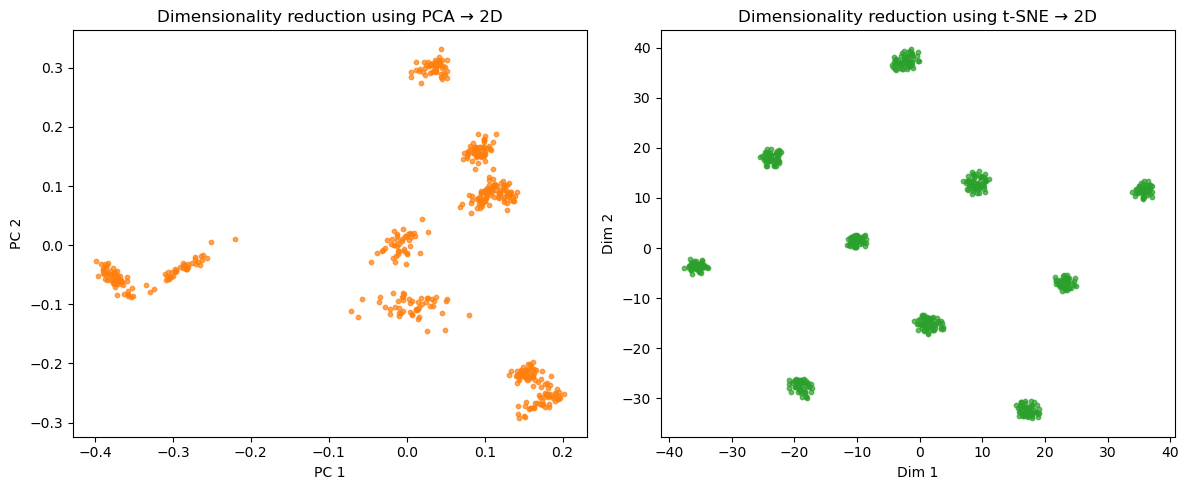

In [274]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

embeddings_pca = reduced_scatter_plot(axes[0], user_avg_list, technique="pca", n_components=2)

embeddings_tsne = reduced_scatter_plot(axes[1], user_avg_list, technique="t-sne", n_components=2, default_color="C2")

plt.tight_layout()
plt.show()


NOTE: T-SNE is usually better for dimension reduction to small dimensions, it doesnt mean it will performe better in a reduction to a fairly high dim like 100-d
but it is usually better for visualizing the clusters in lower dimensions

In [260]:
# Dimension reduction to prepare for clustering 

pca = PCA(n_components=128, svd_solver="randomized", random_state=42)
user_avg_list_pca = pca.fit_transform(user_avg_list)

In [ ]:
# important to remember that all the following lists have the same order
# -> user_list
# -> user_avg_list
# -> user_avg_list_pca

In [ ]:
# Clustering reduced vectors using HDBSCAN

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=8,
    metric="euclidean",
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(user_avg_list_pca)

In [266]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [299]:
# creating map between users and their generated clusters

user_cluster_map = dict(zip(user_list, labels))
cluster_user_map = dict(zip(labels, user_list))

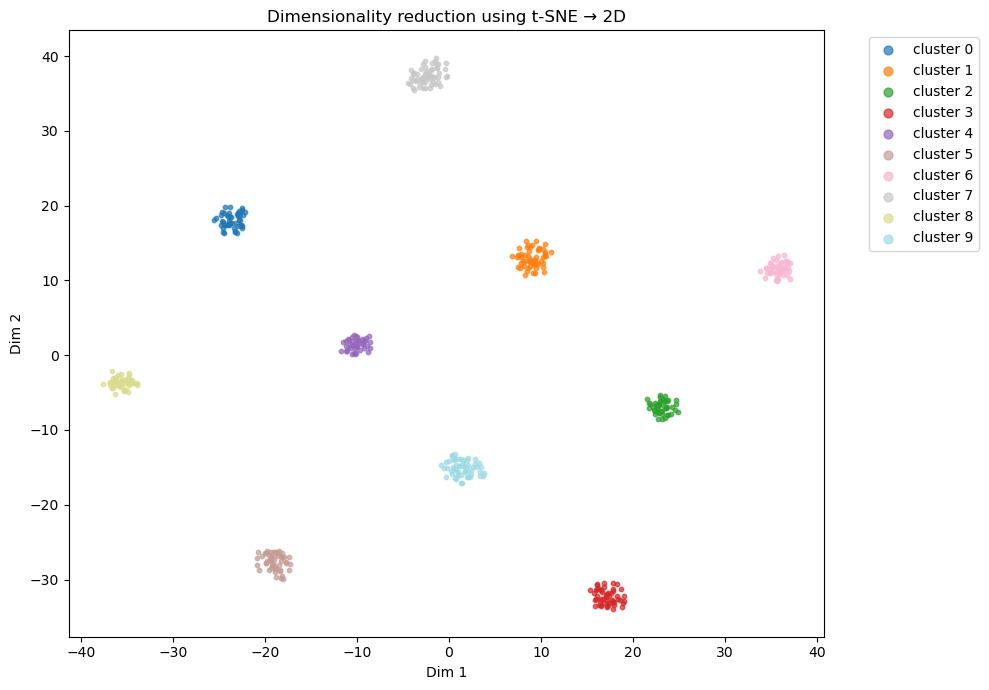

In [ ]:
# Display the clusters in a lower dimensional space
fig, axes = plt.subplots(figsize=(10, 7))

embeddings_pca = reduced_scatter_plot(axes, user_avg_list, labels=labels, technique="t-sne", n_components=2)


plt.tight_layout()
plt.show()

In [ ]:
import re
from collections import Counter, defaultdict

def rank_cluster_words(user_cluster_map, user_queries):
    # 1) Build cluster -> list of users
    cluster_to_users = defaultdict(list)
    for user_id, cluster_label in user_cluster_map.items():
        cluster_to_users[cluster_label].append(user_id)

    # 2) For each cluster, count words across all queries of its users
    cluster_word_counts = {}
    word_pattern = re.compile(r"\w+")

    for cluster_label, users in cluster_to_users.items():
        counter = Counter()
        for user_id in users:
            queries = user_queries.get(user_id, [])
            for query in queries:
                # Extract lowercase words
                words = word_pattern.findall(query.lower())
                counter.update(words)
        # Sort words by count descending
        sorted_word_counts = counter.most_common()
        cluster_word_counts[cluster_label] = sorted_word_counts

    return cluster_word_counts


In [302]:
rankings = rank_cluster_words(user_cluster_map, user_queries)

In [325]:
# My manual naming of the clusters
subjective_names = {}
subjective_names[0] = "Literary Enthusiast"
subjective_names[1] = "Dedicated Pet Parent"
subjective_names[2] = "Smart & Stylish Home Improver"
subjective_names[3] = "Trend-Conscious Luxury Fashion Shopper"
subjective_names[4] = "Performance-Focused Sports Consumer"
subjective_names[5] = "Budget-Conscious Shopper"
subjective_names[6] = "Gourmet & Convenience Food Explorer"
subjective_names[7] = "Nutrition-Conscious Fitness Beginner"
subjective_names[8] = "Tech Enthusiast & Power User"
subjective_names[9] = "Immersive Gaming Gear Seeker"


In [326]:
# Define the new index for user segments
SEG_INDEX_NAME = "user_segments"

mapping = {
    "mappings": {
        "properties": {
            "user_id":  { "type": "keyword" },
            "segment":  { "type": "keyword" }
        }
    }
}

if not es.indices.exists(index=SEG_INDEX_NAME):
    es.indices.create(index=SEG_INDEX_NAME, body=mapping)
    print(f"✅ Created index '{SEG_INDEX_NAME}'.")
else:
    print(f"Index '{SEG_INDEX_NAME}' already exists; skipping creation.")

C:\Users\oussa\AppData\Local\Temp\ipykernel_35572\2959134690.py:13: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  if not es.indices.exists(index=SEG_INDEX_NAME):


✅ Created index 'user_segments'.


C:\Users\oussa\AppData\Local\Temp\ipykernel_35572\2959134690.py:14: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.indices.create(index=SEG_INDEX_NAME, body=mapping)


In [329]:
actions = []
for user_id, cluster_label in user_cluster_map.items():
    segment_name = subjective_names.get(cluster_label, "Unknown")
    action = {
        "_index": SEG_INDEX_NAME,
        "_id": user_id,
        "_source": {
            "user_id": user_id,
            "segment": segment_name
        }
    }
    actions.append(action)

In [ ]:
success_count, errors = helpers.bulk(es, actions, request_timeout=60)
print(f"✅ Indexed segments for {success_count} users into '{SEG_INDEX_NAME}'.")

if errors:
    print("⚠️ Some errors occurred during bulk indexing:")
    for err in errors[:5]:  # show up to first 5 errors
        print(err)

C:\Users\oussa\AppData\Local\Temp\ipykernel_35572\2240753614.py:1: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  success_count, errors = helpers.bulk(es, actions, request_timeout=60)


✅ Indexed segments for 500 users into 'user_searches'.


C:\Users\oussa\AppData\Local\Temp\ipykernel_35572\2240753614.py:1: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  success_count, errors = helpers.bulk(es, actions, request_timeout=60)
